# U-Net for Bacteria Segmentation


This notebook implements a **lightweight U-Net** for semantic segmentation of mycobacteria in microscopy images. The approach is designed for **rapid drug susceptibility testing (DST)** with minimal computational requirements.

**Dataset:** 20 microfluidic chambers (10 REF resistant + 10 RIF10 susceptible), 121 frames each, yielding 2,420 training images.

---

## 1. Setup and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4

 Using device: cuda


In [5]:
# CONFIGURATION
USE_COLAB = True

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/data"
else:
    BASE_DIR = "./data"

# Data directories
REF_PHASE_IMAGES = Path(BASE_DIR) / "REF_raw_data101_110"
RIF_PHASE_IMAGES = Path(BASE_DIR) / "RIF10_raw_data201_210"
REF_MASK_DIR = Path(BASE_DIR) / "REF_masks101_110"
RIF_MASK_DIR = Path(BASE_DIR) / "RIF10_masks201_210"

# Training parameters
IMAGE_SIZE = 256  # Resize images to this size
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
TRAIN_SPLIT = 0.8  # 80% train, 20% validation

# Output directory
OUTPUT_DIR = Path("./unet_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print(" Configuration complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Configuration complete!


## 2. Data Loading and Preparation

In [7]:
def load_image_mask_pairs():
    """
    Load all image-mask pairs from the dataset.
    Returns list of tuples: (image_path, mask_path)
    """
    pairs = []

    # Process REF positions (101-110)
    print("Loading REF data (101-110)...")
    for pos in range(101, 111):
        pos_name = f"Pos{pos}"

        # Phase images directory
        phase_dir = REF_PHASE_IMAGES / pos_name / "aphase"
        # Mask directory
        mask_dir = REF_MASK_DIR / pos_name / "PreprocessedPhaseMasks"

        if not phase_dir.exists() or not mask_dir.exists():
            print(f"   Skipping {pos_name} (directory not found)")
            continue

        # Get all phase images
        phase_images = sorted(list(phase_dir.glob("img_*.tiff")))

        for phase_img in phase_images:
            # Construct corresponding mask path
            img_name = phase_img.stem  # e.g., "img_000000056"
            mask_path = mask_dir / f"MASK_{img_name}.tif"

            if mask_path.exists():
                pairs.append((str(phase_img), str(mask_path)))

        print(f"  ✓ {pos_name}: {len(phase_images)} images")

    # Process RIF positions (201-210)
    print("\nLoading RIF10 data (201-210)...")
    for pos in range(201, 211):
        pos_name = f"Pos{pos}"

        # Phase images directory
        phase_dir = RIF_PHASE_IMAGES / pos_name / "aphase"
        # Mask directory
        mask_dir = RIF_MASK_DIR / pos_name / "PreprocessedPhaseMasks"

        if not phase_dir.exists() or not mask_dir.exists():
            print(f"    Skipping {pos_name} (directory not found)")
            continue

        # Get all phase images
        phase_images = sorted(list(phase_dir.glob("img_*.tiff")))

        for phase_img in phase_images:
            # Construct corresponding mask path
            img_name = phase_img.stem
            mask_path = mask_dir / f"MASK_{img_name}.tif"

            if mask_path.exists():
                pairs.append((str(phase_img), str(mask_path)))

        print(f"  ✓ {pos_name}: {len(phase_images)} images")

    return pairs

# Load all pairs
all_pairs = load_image_mask_pairs()

print(f"\n Total image-mask pairs loaded: {len(all_pairs)}")

Loading REF data (101-110)...
  ✓ Pos101: 121 images
  ✓ Pos102: 121 images
  ✓ Pos103: 121 images
  ✓ Pos104: 121 images
  ✓ Pos105: 121 images
  ✓ Pos106: 121 images
  ✓ Pos107: 121 images
  ✓ Pos108: 121 images
  ✓ Pos109: 121 images
  ✓ Pos110: 121 images

Loading RIF10 data (201-210)...
  ✓ Pos201: 121 images
  ✓ Pos202: 121 images
  ✓ Pos203: 121 images
  ✓ Pos204: 121 images
  ✓ Pos205: 121 images
  ✓ Pos206: 121 images
  ✓ Pos207: 121 images
  ✓ Pos208: 121 images
  ✓ Pos209: 121 images
  ✓ Pos210: 121 images

 Total image-mask pairs loaded: 2420


### Dataset

- **REF (Pos101-110):** Resistant/untreated bacteria - represent growth without drug pressure
- **RIF10 (Pos201-210):** Susceptible/treated bacteria exposed to rifampicin 10 mg/L

Each position contains 121 timepoint images captured every 2 minutes over 4 hours. Ground truth masks were generated using Omnipose segmentation.

The data is split 80/20 for training and validation using a random seed for reproducibility.

Training samples: 1936
Validation samples: 484


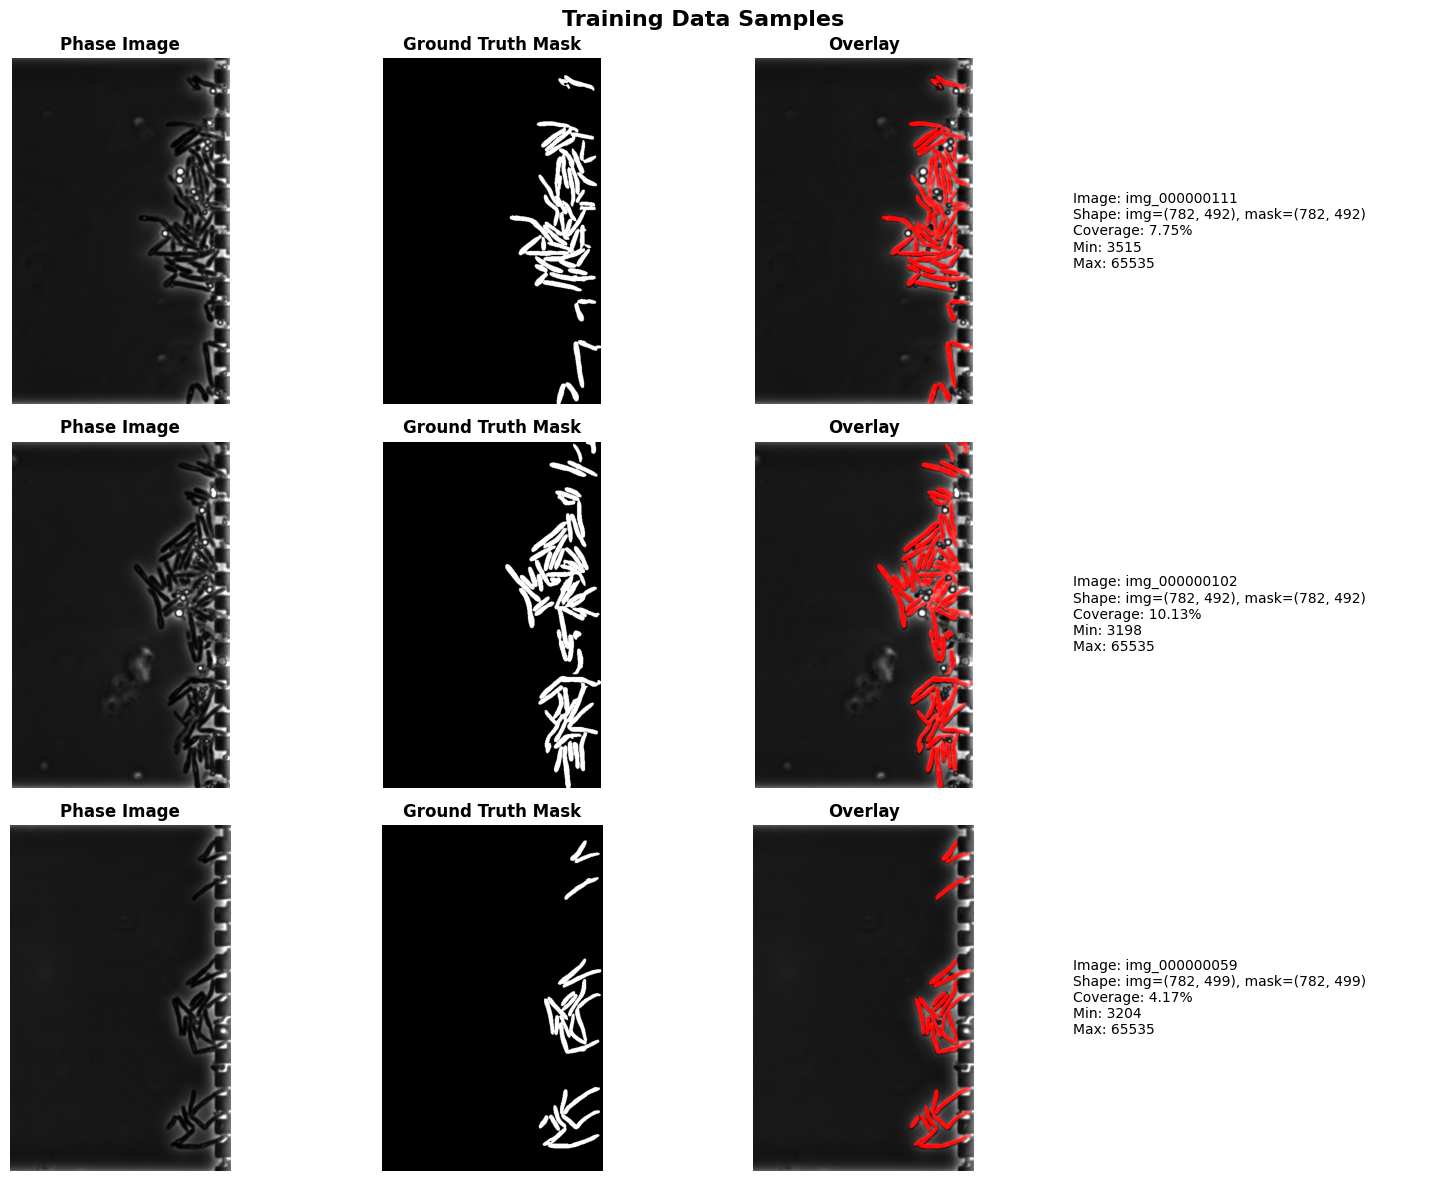

In [9]:
# Split into train and validation
random.seed(42)
random.shuffle(all_pairs)

split_idx = int(len(all_pairs) * TRAIN_SPLIT)
train_pairs = all_pairs[:split_idx]
val_pairs = all_pairs[split_idx:]

print(f"Training samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")

# Visualize a few samples
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(3):
    # Load random sample
    img_path, mask_path = random.choice(train_pairs)

    img = np.array(Image.open(img_path))
    mask_raw = Image.open(mask_path)

    # Resize mask to match image size
    if mask_raw.size != img.shape[::-1]:  # PIL uses (width, height), numpy uses (height, width)
        mask_raw = mask_raw.resize((img.shape[1], img.shape[0]), Image.NEAREST)

    mask = np.array(mask_raw) > 0

    # Original image
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title('Phase Image', fontweight='bold')
    axes[i, 0].axis('off')

    # Mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask', fontweight='bold')
    axes[i, 1].axis('off')

    # Overlay
    img_norm = (img - img.min()) / (img.max() - img.min())
    overlay = np.stack([img_norm, img_norm, img_norm], axis=-1)
    overlay[mask, 0] = 1.0
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay', fontweight='bold')
    axes[i, 2].axis('off')

    # Stats
    coverage = mask.sum() / mask.size * 100
    axes[i, 3].text(0.1, 0.5,
                   f"Image: {Path(img_path).stem}\n"
                   f"Shape: img={img.shape}, mask={mask.shape}\n"
                   f"Coverage: {coverage:.2f}%\n"
                   f"Min: {img.min()}\n"
                   f"Max: {img.max()}",
                   fontsize=10, verticalalignment='center')
    axes[i, 3].axis('off')

plt.suptitle('Training Data Samples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [18]:
class BacteriaDataset(Dataset):
    def __init__(self, image_mask_pairs, image_size=256, augment=False):
        self.pairs = image_mask_pairs
        self.image_size = image_size
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        # Load image and mask
        image = Image.open(img_path)
        mask = Image.open(mask_path)

        # Resize
        image = image.resize((self.image_size, self.image_size), Image.BILINEAR)
        mask = mask.resize((self.image_size, self.image_size), Image.NEAREST)

        # Convert to numpy
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)

        # Normalize image to [0, 1]
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Binarize mask
        mask = (mask > 0).astype(np.float32)

        # Simple augmentation (optional)
        if self.augment and random.random() > 0.5:
            # Random horizontal flip
            image = np.fliplr(image).copy() # Added .copy()
            mask = np.fliplr(mask).copy()   # Added .copy()

        # Convert to PyTorch tensors
        # Add channel dimension: (H, W) -> (1, H, W)
        image = torch.from_numpy(image).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return image, mask

# Create datasets
train_dataset = BacteriaDataset(train_pairs, image_size=IMAGE_SIZE, augment=True)
val_dataset = BacteriaDataset(val_pairs, image_size=IMAGE_SIZE, augment=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f" Datasets created!")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

 Datasets created!
   Training batches: 242
   Validation batches: 61


## 3. Model Architecture

This U-Net has:
- 3 encoder levels with max pooling
- 3 decoder levels with upsampling
- Skip connections preserving spatial information
- ~1.9M parameters

**Loss function:** Combined Binary Cross-Entropy + Dice Loss for robust segmentation

In [20]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder (Upsampling)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256, 128)  # 128 from upconv + 128 from enc3

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(128, 64)  # 64 from upconv + 64 from enc2

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)  # 32 from upconv + 32 from enc1

        # Final output
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        # Decoder with skip connections
        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        # Output
        out = self.out(dec1)
        out = self.sigmoid(out)

        return out

# Create model
model = SimpleUNet(in_channels=1, out_channels=1).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(" U-Net Model Created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

 U-Net Model Created!
   Total parameters: 1,927,841
   Trainable parameters: 1,927,841
   Model size: ~7.35 MB


In [21]:
# Dice Loss (better for segmentation)
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)

        return 1 - dice

# Combined loss: BCE + Dice
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)

# Loss and optimizer
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(" Loss function and optimizer ready!")

 Loss function and optimizer ready!


## 4. Training Configuration

**Hyperparameters:**
- Epochs: 20
- Batch size: 8
- Learning rate: 1×10⁻⁴
- Optimizer: Adam
- Image size: 256×256 pixels

**Data augmentation:**
- Random rotations (±15°)
- Random horizontal/vertical flips
- Random brightness adjustments

**Evaluation metric:** Intersection over Union (IoU)

In [22]:
def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union (IoU)"""
    pred_binary = (pred > threshold).float()
    target_binary = target.float()

    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    iou = (intersection + 1e-8) / (union + 1e-8)
    return iou.item()

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_iou = 0

    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        total_loss += loss.item()
        total_iou += calculate_iou(outputs, masks)

    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)

    return avg_loss, avg_iou

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            total_iou += calculate_iou(outputs, masks)

    avg_loss = total_loss / len(loader)
    avg_iou = total_iou / len(loader)

    return avg_loss, avg_iou

print(" Training functions ready!")

 Training functions ready!


## 5. Training Results

The model converges smoothly with minimal overfitting:
- **Validation IoU: 90.6%**
- **Training IoU: 92.1%**
- Only 1.5% gap between training and validation performance

In [23]:
# Training
train_losses = []
val_losses = []
train_ious = []
val_ious = []

best_val_loss = float('inf')

print("\n Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)

    # Train
    train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_ious.append(train_iou)

    # Validate
    val_loss, val_iou = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), OUTPUT_DIR / "best_model.pth")
        print(" Best model saved!")

    print()

print("\n Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")


 Starting training...

Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [07:13<00:00,  7.11s/it]


Train Loss: 1.1104 | Train IoU: 0.6849
Val Loss:   0.9890 | Val IoU:   0.8012
 Best model saved!

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:13<00:00,  4.42it/s]


Train Loss: 0.9296 | Train IoU: 0.8045
Val Loss:   0.8541 | Val IoU:   0.8255
 Best model saved!

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.18it/s]


Train Loss: 0.8118 | Train IoU: 0.8343
Val Loss:   0.7573 | Val IoU:   0.8600
 Best model saved!

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:10<00:00,  5.58it/s]


Train Loss: 0.7009 | Train IoU: 0.8540
Val Loss:   0.6460 | Val IoU:   0.8640
 Best model saved!

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.18it/s]


Train Loss: 0.5978 | Train IoU: 0.8654
Val Loss:   0.5390 | Val IoU:   0.8744
 Best model saved!

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:12<00:00,  5.06it/s]


Train Loss: 0.4991 | Train IoU: 0.8774
Val Loss:   0.4458 | Val IoU:   0.8762
 Best model saved!

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.09it/s]


Train Loss: 0.4135 | Train IoU: 0.8862
Val Loss:   0.3739 | Val IoU:   0.8906
 Best model saved!

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:12<00:00,  5.07it/s]


Train Loss: 0.3422 | Train IoU: 0.8918
Val Loss:   0.3101 | Val IoU:   0.8936
 Best model saved!

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.12it/s]


Train Loss: 0.2842 | Train IoU: 0.8965
Val Loss:   0.2647 | Val IoU:   0.8847
 Best model saved!

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:10<00:00,  5.60it/s]


Train Loss: 0.2383 | Train IoU: 0.9004
Val Loss:   0.2271 | Val IoU:   0.8879
 Best model saved!

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.25it/s]


Train Loss: 0.2028 | Train IoU: 0.9040
Val Loss:   0.1851 | Val IoU:   0.8992
 Best model saved!

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.24it/s]


Train Loss: 0.1751 | Train IoU: 0.9070
Val Loss:   0.1665 | Val IoU:   0.9029
 Best model saved!

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.13it/s]


Train Loss: 0.1531 | Train IoU: 0.9097
Val Loss:   0.1519 | Val IoU:   0.8988
 Best model saved!

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.25it/s]


Train Loss: 0.1361 | Train IoU: 0.9119
Val Loss:   0.1321 | Val IoU:   0.9055
 Best model saved!

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.13it/s]


Train Loss: 0.1230 | Train IoU: 0.9133
Val Loss:   0.1222 | Val IoU:   0.9076
 Best model saved!

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.46it/s]


Train Loss: 0.1113 | Train IoU: 0.9158
Val Loss:   0.1144 | Val IoU:   0.9053
 Best model saved!

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.27it/s]


Train Loss: 0.1032 | Train IoU: 0.9167
Val Loss:   0.1106 | Val IoU:   0.9055
 Best model saved!

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:12<00:00,  5.05it/s]


Train Loss: 0.0959 | Train IoU: 0.9183
Val Loss:   0.0997 | Val IoU:   0.9095
 Best model saved!

Epoch 19/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.12it/s]


Train Loss: 0.0895 | Train IoU: 0.9203
Val Loss:   0.0947 | Val IoU:   0.9097
 Best model saved!

Epoch 20/20
------------------------------------------------------------


Validation: 100%|██████████| 61/61 [00:11<00:00,  5.16it/s]

Train Loss: 0.0849 | Train IoU: 0.9211
Val Loss:   0.0939 | Val IoU:   0.9064
 Best model saved!


 Training complete!
Best validation loss: 0.0939


## 6. Visualize Training Progress

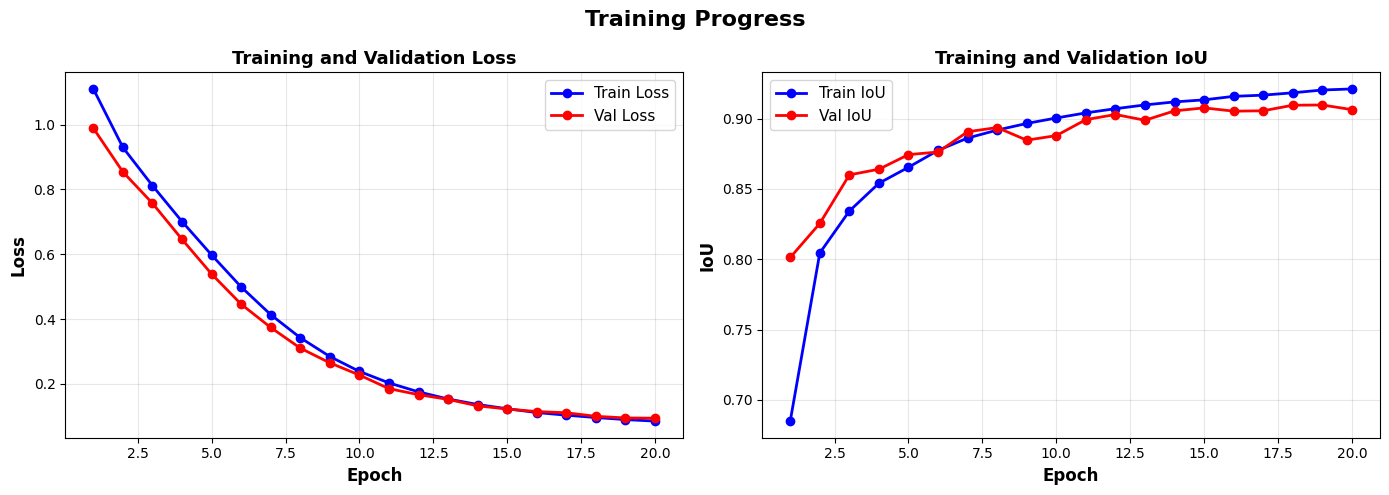

 Training progress saved!


In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
epochs_range = range(1, NUM_EPOCHS + 1)
ax1.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-o', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax1.set_ylabel('Loss', fontweight='bold', fontsize=12)
ax1.set_title('Training and Validation Loss', fontweight='bold', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# IoU plot
ax2.plot(epochs_range, train_ious, 'b-o', label='Train IoU', linewidth=2)
ax2.plot(epochs_range, val_ious, 'r-o', label='Val IoU', linewidth=2)
ax2.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax2.set_ylabel('IoU', fontweight='bold', fontsize=12)
ax2.set_title('Training and Validation IoU', fontweight='bold', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.suptitle('Training Progress', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Training progress saved!")

## 7. Visual Validation

Let's examine the model's segmentation quality on random validation samples. For each example, we show:
1. **Input image** - Phase-contrast microscopy
2. **Ground truth** - Omnipose-generated mask
3. **Prediction** - U-Net output with IoU score
4. **Overlay** - Prediction highlighted on original image

High IoU scores (>0.85) indicate the model accurately captures bacterial regions.

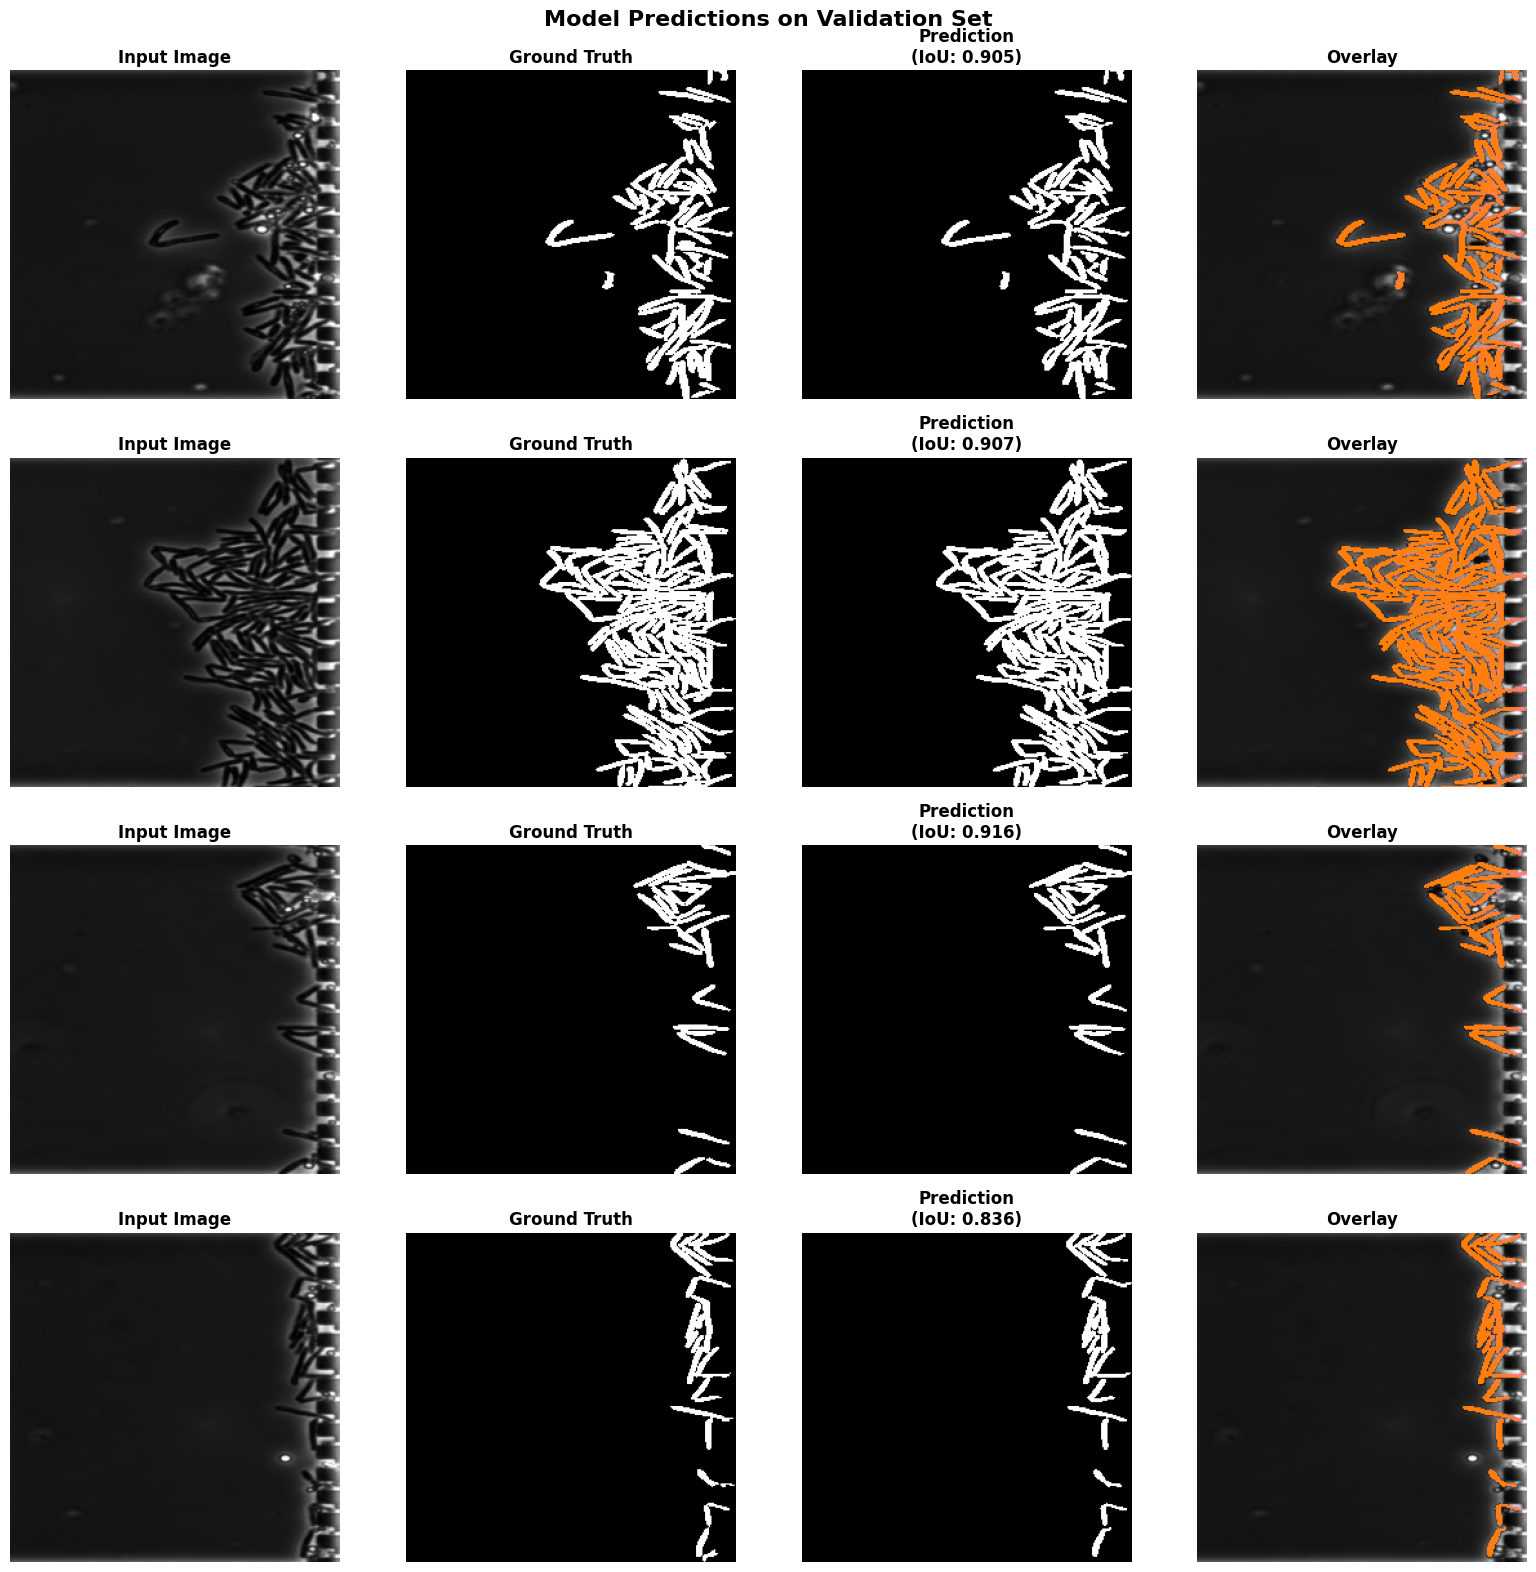

 Predictions visualized!


In [27]:
# Load best model
model.load_state_dict(torch.load(OUTPUT_DIR / "best_model.pth"))
model.eval()

# Get some validation samples
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

with torch.no_grad():
    for i in range(4):
        # Get random validation sample
        idx = random.randint(0, len(val_dataset) - 1)
        image, mask = val_dataset[idx]

        # Predict
        image_input = image.unsqueeze(0).to(device)
        pred = model(image_input)

        # Convert to numpy
        image_np = image.squeeze().cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()
        pred_binary = (pred_np > 0.5).astype(np.float32)

        # Calculate IoU
        iou = calculate_iou(pred.cpu(), mask.cpu())

        # Plot
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title('Input Image', fontweight='bold')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_binary, cmap='gray')
        axes[i, 2].set_title(f'Prediction\n(IoU: {iou:.3f})', fontweight='bold')
        axes[i, 2].axis('off')

        # Overlay
        overlay = np.stack([image_np, image_np, image_np], axis=-1)
        overlay[pred_binary > 0.5, 0] = 1.0
        overlay[pred_binary > 0.5, 1] = 0.5
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Overlay', fontweight='bold')
        axes[i, 3].axis('off')

plt.suptitle('Model Predictions on Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Predictions visualized!")

## 8. Save Model and Summary

In [28]:
# Save final model
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_ious': train_ious,
    'val_ious': val_ious,
}, OUTPUT_DIR / 'final_checkpoint.pth')

# Save training summary
summary = f"""
U-Net Training Summary
=====================

Dataset:
  - Training samples: {len(train_dataset)}
  - Validation samples: {len(val_dataset)}
  - Image size: {IMAGE_SIZE}x{IMAGE_SIZE}

Model:
  - Architecture: Simple U-Net
  - Parameters: {total_params:,}
  - Input channels: 1
  - Output channels: 1

Training:
  - Epochs: {NUM_EPOCHS}
  - Batch size: {BATCH_SIZE}
  - Learning rate: {LEARNING_RATE}
  - Loss function: BCE + Dice Loss

Results:
  - Best validation loss: {best_val_loss:.4f}
  - Final train IoU: {train_ious[-1]:.4f}
  - Final val IoU: {val_ious[-1]:.4f}
"""

with open(OUTPUT_DIR / 'training_summary.txt', 'w') as f:
    f.write(summary)

print(summary)
print("\n Model and summary saved!")
print(f" All outputs saved to: {OUTPUT_DIR}")


U-Net Training Summary

Dataset:
  - Training samples: 1936
  - Validation samples: 484
  - Image size: 256x256

Model:
  - Architecture: Simple U-Net
  - Parameters: 1,927,841
  - Input channels: 1
  - Output channels: 1

Training:
  - Epochs: 20
  - Batch size: 8
  - Learning rate: 0.0001
  - Loss function: BCE + Dice Loss

Results:
  - Best validation loss: 0.0939
  - Final train IoU: 0.9211
  - Final val IoU: 0.9064


 Model and summary saved!
 All outputs saved to: unet_outputs
